In [33]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

import pickle

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn import metrics

from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

In [34]:
test_data_size = 1500

prediction_time = 16
unroll_length = 672

# Prepare Data

In [35]:
try:
    df= pd.read_csv("./data/WF1_632822_20181120.txt")
    df.columns = ['datetime', 'value']
except Exception as e:
    print("file doesn't exist")

In [36]:
df.head()

,datetime,value
0,2018-01-01 00:00:00,-0.41
1,2018-01-01 00:15:00,-0.41
2,2018-01-01 00:30:00,-0.41
3,2018-01-01 00:45:00,-0.02
4,2018-01-01 01:00:00,0.64


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30912 entries, 0 to 30911
Data columns (total 2 columns):
datetime    30912 non-null object
value       24213 non-null float64
dtypes: float64(1), object(1)
memory usage: 483.1+ KB


In [38]:
df['datetime'] = pd.to_datetime(df['datetime'])
sns.heatmap(df.isnull(), cbar=False)

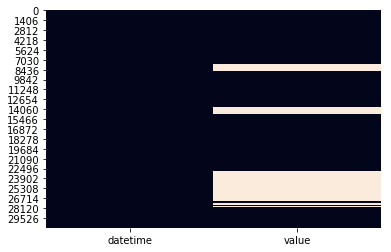

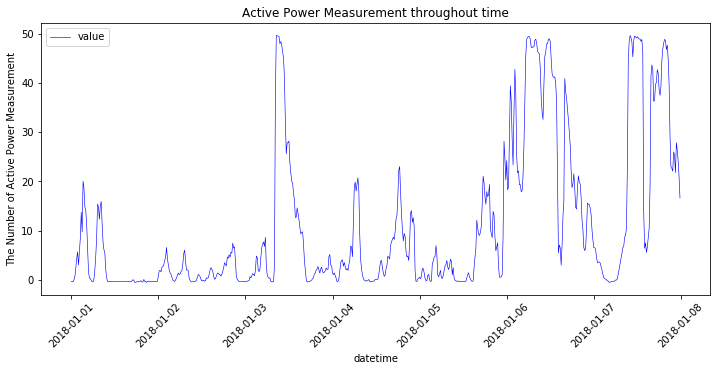

In [39]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(df['datetime'][0: 672], df['value'][0: 672], color='blue', linewidth=0.6)
ax.set_title('Active Power Measurement throughout time')

plt.xlabel('datetime')
plt.xticks(rotation=45) 
plt.ylabel('The Number of Active Power Measurement')
plt.legend(loc='upper left')
plt.show()

In [40]:
df.dropna(axis=0, how='any', inplace=True)

df['datetime'] = pd.to_datetime(df['datetime'])

df['hour'] = df['datetime'].dt.hour
df['day'] = df['datetime'].dt.day
df['month'] = df['datetime'].dt.month

df['day_of_week'] = df['datetime'].dt.dayofweek

In [41]:
df = df.reset_index()

In [42]:
df.count()

index          24213
datetime       24213
value          24213
hour           24213
day            24213
month          24213
day_of_week    24213
dtype: int64

In [43]:
index = pd.date_range(start='2018-01-01', end='2018-11-18', freq='15min')
print(index)

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 00:15:00',
               '2018-01-01 00:30:00', '2018-01-01 00:45:00',
               '2018-01-01 01:00:00', '2018-01-01 01:15:00',
               '2018-01-01 01:30:00', '2018-01-01 01:45:00',
               '2018-01-01 02:00:00', '2018-01-01 02:15:00',
               ...
               '2018-11-17 21:45:00', '2018-11-17 22:00:00',
               '2018-11-17 22:15:00', '2018-11-17 22:30:00',
               '2018-11-17 22:45:00', '2018-11-17 23:00:00',
               '2018-11-17 23:15:00', '2018-11-17 23:30:00',
               '2018-11-17 23:45:00', '2018-11-18 00:00:00'],
              dtype='datetime64[ns]', length=30817, freq='15T')


In [44]:
X = []
Y = []

for i in range(len(index)-prediction_time-unroll_length):
    
    X_mask = (df['datetime'] >= index[i]) & (df['datetime'] < index[i+unroll_length])
    X_tmp = df.loc[X_mask][['value', 'hour', 'day', 'month', 'day_of_week']]
    
    Y_mask = (df['datetime'] >= index[i+unroll_length]) & (df['datetime'] < index[i+prediction_time+unroll_length])
    Y_tmp = df.loc[Y_mask]['value']
    
    if (X_tmp.shape[0]==unroll_length) and (Y_tmp.shape[0]==prediction_time):
        #print("Not NaN, append!")
        X_tmp = X_tmp.values.tolist()
        Y_tmp = Y_tmp.tolist()
        X.append(X_tmp)
        Y.append(Y_tmp)
        

In [45]:
X = np.asarray(X)
Y = np.asarray(Y)

print(X.shape)
print(Y.shape)
print(X[0:2])
print(Y[0:2])

(17243, 672, 5)
(17243, 16)
[[[-4.100e-01  0.000e+00  1.000e+00  1.000e+00  0.000e+00]
  [-4.100e-01  0.000e+00  1.000e+00  1.000e+00  0.000e+00]
  [-4.100e-01  0.000e+00  1.000e+00  1.000e+00  0.000e+00]
  ...
  [ 2.411e+01  2.300e+01  7.000e+00  1.000e+00  6.000e+00]
  [ 2.087e+01  2.300e+01  7.000e+00  1.000e+00  6.000e+00]
  [ 1.661e+01  2.300e+01  7.000e+00  1.000e+00  6.000e+00]]

 [[-4.100e-01  0.000e+00  1.000e+00  1.000e+00  0.000e+00]
  [-4.100e-01  0.000e+00  1.000e+00  1.000e+00  0.000e+00]
  [-2.000e-02  0.000e+00  1.000e+00  1.000e+00  0.000e+00]
  ...
  [ 2.087e+01  2.300e+01  7.000e+00  1.000e+00  6.000e+00]
  [ 1.661e+01  2.300e+01  7.000e+00  1.000e+00  6.000e+00]
  [ 1.199e+01  0.000e+00  8.000e+00  1.000e+00  0.000e+00]]]
[[11.99  8.19  2.9   0.45  0.21  0.38 -0.33 -0.5  -0.42 -0.41 -0.45 -0.44
  -0.44 -0.43 -0.43 -0.43]
 [ 8.19  2.9   0.45  0.21  0.38 -0.33 -0.5  -0.42 -0.41 -0.45 -0.44 -0.44
  -0.43 -0.43 -0.43 -0.42]]


In [46]:
X_file = open("./X.pkl", 'wb')
pickle.dump(X, X_file)
X_file.close()

Y_file = open("./Y.pkl", 'wb')
pickle.dump(Y, Y_file)
Y_file.close()

# Load Dataset

In [47]:
X_file = open("./X.pkl", 'rb')
X = pickle.load(X_file)
X_file.close()

Y_file = open("./Y.pkl", 'rb')
Y = pickle.load(Y_file)
Y_file.close()
print(X.shape)
print(Y.shape)

(17243, 672, 5)
(17243, 16)


In [48]:
X_train = X[0: -test_data_size]
X_test = X[-test_data_size: ]

y_train = Y[0: -test_data_size]
y_test = Y[-test_data_size: ]

print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(15743, 672, 5)
(1500, 672, 5)
(15743, 16)
(1500, 16)


In [49]:
X_min_max_scaler = preprocessing.MinMaxScaler()
y_min_max_scaler = preprocessing.MinMaxScaler()

X_train = X_min_max_scaler.fit_transform(X_train.reshape(-1, 5)).reshape(-1, unroll_length, 5)
X_test = X_min_max_scaler.transform(X_test.reshape(-1, 5)).reshape(-1, unroll_length, 5)


y_min_max_scaler.fit(y_train.reshape(-1, 1))

print(y_min_max_scaler.data_min_)
print(y_min_max_scaler.data_max_)

print(X_min_max_scaler.data_min_)
print(X_min_max_scaler.data_max_)

y_min_max_scaler.data_min_[0] = X_min_max_scaler.data_min_[0]
y_min_max_scaler.data_max_[0] = X_min_max_scaler.data_max_[0]

label_min = X_min_max_scaler.data_min_[0]
label_max = X_min_max_scaler.data_max_[0]

y_train = y_min_max_scaler.transform(y_train.reshape(-1, 1)).reshape(-1, 16)
y_test = y_min_max_scaler.transform(y_test.reshape(-1, 1)).reshape(-1, 16)

[-0.57]
[104.12]
[-0.59  0.    1.    1.    0.  ]
[104.12  23.    31.     8.     6.  ]


The major problem is that bigdl's lstm does not have "return_state" and "initial_state".

In [50]:
y_train = np.expand_dims(y_train, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)
print(y_train.shape)
print(y_test.shape)

(15743, 16, 1)
(1500, 16, 1)


# Build Model

In [51]:
latent_dim = 16 # LSTM hidden units
dropout = .20 

# Define an input series and encode it with an LSTM. 
encoder_inputs = Input(shape=(None, 5)) 
encoder = LSTM(latent_dim, dropout=dropout, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the final states. These represent the "context"
# vector that we use as the basis for decoding.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
# This is where teacher forcing inputs are fed in.
decoder_inputs = Input(shape=(None, 1)) 

# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, dropout=dropout, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)

decoder_dense = Dense(1) # 1 continuous output at each timestep
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [52]:
batch_size = 1024
epochs = 5

# sample of series from train_enc_start to train_enc_end  
encoder_input_data = X_train

# sample of series from train_pred_start to train_pred_end 
decoder_target_data = y_train

# lagged target series for teacher forcing
decoder_input_data = np.zeros(decoder_target_data.shape)
decoder_input_data[:,1:,0] = decoder_target_data[:,:-1,0]
decoder_input_data[:,0,0] = encoder_input_data[:,-1,0]

model.compile(Adam(), loss='mean_absolute_error')

In [53]:
%%time

checkpoint = ModelCheckpoint("./best_model.h5", monitor='val_loss', verbose=2, save_best_only=True, mode='min')

history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                     batch_size=batch_size,
                     epochs=epochs,
                     validation_split=0.1,
                     callbacks=[checkpoint])

Train on 14168 samples, validate on 1575 samples
Epoch 1/5
14168/14168 [==============================] - 13s 902us/step - loss: 0.2340 - val_loss: 0.1864

Epoch 00001: val_loss improved from inf to 0.18638, saving model to ./best_model.h5


/Library/Python/2.7/site-packages/keras/engine/network.py:877: UserWarning: Layer lstm_4 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_3/while/Exit_2:0' shape=(?, 16) dtype=float32>, <tf.Tensor 'lstm_3/while/Exit_3:0' shape=(?, 16) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/5
14168/14168 [==============================] - 11s 755us/step - loss: 0.1872 - val_loss: 0.1455

Epoch 00002: val_loss improved from 0.18638 to 0.14550, saving model to ./best_model.h5
Epoch 3/5
14168/14168 [==============================] - 11s 747us/step - loss: 0.1500 - val_loss: 0.1061

Epoch 00003: val_loss improved from 0.14550 to 0.10608, saving model to ./best_model.h5
Epoch 4/5
14168/14168 [==============================] - 11s 756us/step - loss: 0.1261 - val_loss: 0.0898

Epoch 00004: val_loss improved from 0.10608 to 0.08978, saving model to ./best_model.h5
Epoch 5/5
14168/14168 [==============================] - 11s 750us/step - loss: 0.1196 - val_loss: 0.0856

Epoch 00005: val_loss improved from 0.08978 to 0.08558, saving model to ./best_model.h5
CPU times: user 2min 20s, sys: 1min, total: 3min 21s
Wall time: 57.3 s


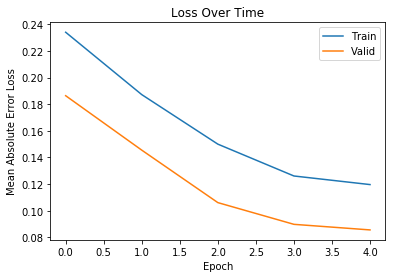

In [54]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])
plt.show()

In [55]:
model.load_weights("./best_model.h5")

In [56]:
# from our previous model - mapping encoder sequence to state vectors
encoder_model = Model(encoder_inputs, encoder_states)

# A modified version of the decoding stage that takes in predicted target inputs
# and encoded state vectors, returning predicted target outputs and decoder state vectors.
# We need to hang onto these state vectors to run the next step of the inference loop.
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                      [decoder_outputs] + decoder_states)

def decode_sequence(input_seq):
    
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, 1))
    
    # Populate the first target sequence with end of encoding series pageviews
    target_seq[0, 0, 0] = input_seq[0, -1, 0]

    # Sampling loop for a batch of sequences - we will fill decoded_seq with predictions
    # (to simplify, here we assume a batch of size 1).

    decoded_seq = np.zeros((1,prediction_time,1))
    
    for i in range(prediction_time):
        
        output, h, c = decoder_model.predict([target_seq] + states_value)
        
        decoded_seq[0,i,0] = output[0,0,0]

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, 1))
        target_seq[0, 0, 0] = output[0,0,0]

        # Update states
        states_value = [h, c]

    return decoded_seq

In [57]:
encoder_input_data = X_test
decoder_target_data = y_test

In [58]:
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ind, enc_tail_len=unroll_length):

    encode_series = encoder_input_data[sample_ind:sample_ind+1,:,:] 
    pred_series = decode_sequence(encode_series)
        
    encode_series = encode_series[:, :, 0].reshape(-1,1)
    
    pred_series = pred_series.reshape(-1,1)
    
    target_series = decoder_target_data[sample_ind,:,:1].reshape(-1,1) 
    
    
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    
    
    plt.figure(figsize=(10,6))   
    
    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(range(x_encode,x_encode+prediction_time),target_series,color='orange')
    plt.plot(range(x_encode,x_encode+prediction_time),pred_series,color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])

In [59]:
predict_and_plot(encoder_input_data, decoder_target_data, 16)

In [60]:
%%time
p = []

for sample_ind in range(y_test.shape[0]):
#     print(sample_ind)
    encode_series = encoder_input_data[sample_ind:sample_ind+1,:,:] 
    pred_series = decode_sequence(encode_series)
    
    pred_series = pred_series.reshape(-1,1)   
    
    p.append(pred_series)

CPU times: user 3min 51s, sys: 1min 35s, total: 5min 26s
Wall time: 1min 39s


In [61]:
print("RMSE:",np.sqrt(metrics.mean_squared_error(np.squeeze(y_test), np.squeeze(np.asarray(p))))*(label_max-label_min))

('RMSE:', 20.688293730353866)
